# Cardiovascular Disease Detection using PySpark

## Table of Contents
1. [Project Scope](#projectscope)
2. [Setup and Libraries](#setup)
3. [Data Wrangling](#wrangling)
    - [Data Extraction](#extraction)
    - [Helper Functions](#helper)
    - [Partitioning the Data](#partition)
    - [Missing Values](#missing)
    - [Numerical Data Analysis](#num)
    - [Outlier and Skewness Analysis](#outskew)
    - [Binning](#bin)
    - [Categorical Data Analysis](#cat)
4. [Machine Learning](#ml)
5. [Conclusion](#conc)

In [1]:
from IPython.display import HTML
HTML("<center><img src='./data/heart_disease.png'/></center>")

## 1. Project Scope <a name="projectscope"></a>
---

Data source for this project is the [cardiovascular detection dataset from kaggle](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset). This dataset contains 70,000 rows and 12 explanatory variables and binary response variable that we'll be using for classification

The purpose of this project is to utilize PySpark functions for data extraction, feature engineering and machine learning algorithms to determine whether or not an individual potentially has a cardiovascular disease.

## 2. Setup and Libraries <a name="setup"></a>
---

In [2]:
import findspark
findspark.init()

import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, expr, count, when, isnan, skewness
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName("Cardiovascular Disease Detection") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config ("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

## 3. Data Wrangling <a name="wrangling"></a>
---

### Data Extraction <a name="extraction"></a>

In [4]:
csv_data = spark.read.format("csv")\
        .option("header","true")\
        .option("timestamp","true")\
        .option("delimiter",";")\
        .option("partitionBy", "ap_hi") \
        .load("./data/cardio_train.csv")
csv_data = csv_data.withColumn("age", col("Age")/365)
print('Dataframe Preview')
csv_data.show(10)

Dataframe Preview
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|               age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|50.391780821917806|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1| 55.41917808219178|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2| 51.66301369863014|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3| 48.28219178082192|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4| 47.87397260273973|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|60.038356164383565|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|60.583561643835615|     1|   157|  93.0|  130|   80|          3|   1|    0|  

In [5]:
def update_categorical(df, var_list, desc_mapping):
    df_updated = df
    for var in var_list:
        var_desc = desc_mapping.get(var)
        df_updated = df_updated.withColumn(f"{var}", var_desc[col(var)])
    return df_updated

expr_map = {
    'gender': expr("map('1', 'Women', '2', 'Men')"),
    'cholesterol': expr("map('1','Normal', '2','Above Normal', '3', 'Well Above Normal')"),
    'gluc': expr("map('1','Normal', '2','Above Normal', '3', 'Well Above Normal')"),
    'smoke': expr("map('0', 'No', '1', 'Yes')"),
    'active': expr("map('0', 'No', '1', 'Yes')"),
    'alco': expr("map('0', 'No', '1', 'Yes')"),
    'cardio': expr("map('0', 'No', '1', 'Yes')")
}

data_updated = update_categorical(csv_data, list(expr_map.keys()), expr_map)
data_updated.show(5)

+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
| id|               age|gender|height|weight|ap_hi|ap_lo|      cholesterol|  gluc|smoke|alco|active|cardio|
+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
|  0|50.391780821917806|   Men|   168|  62.0|  110|   80|           Normal|Normal|   No|  No|   Yes|    No|
|  1| 55.41917808219178| Women|   156|  85.0|  140|   90|Well Above Normal|Normal|   No|  No|   Yes|   Yes|
|  2| 51.66301369863014| Women|   165|  64.0|  130|   70|Well Above Normal|Normal|   No|  No|    No|   Yes|
|  3| 48.28219178082192|   Men|   169|  82.0|  150|  100|           Normal|Normal|   No|  No|   Yes|   Yes|
|  4| 47.87397260273973| Women|   156|  56.0|  100|   60|           Normal|Normal|   No|  No|    No|    No|
+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
only showing top 5 rows



Mapping the categorical variables here to help better understand the data. All these columns will be one-hot encoded when preparing the ML pipeline.

In [6]:
cardio_data = data_updated\
                .withColumnRenamed("id", "ID").withColumn("ID", col("ID").cast("int"))\
                .withColumnRenamed("age", "Age").withColumn("Age", col("Age").cast("int"))\
                .withColumnRenamed("gender", "Gender").withColumn("Gender", col("Gender").cast("string"))\
                .withColumnRenamed("height", "Height").withColumn("Height", col("Height").cast("int"))\
                .withColumnRenamed("weight", "Weight").withColumn("Weight", col("Weight").cast("float"))\
                .withColumnRenamed("ap_hi", "SystolicBP").withColumn("SystolicBP", col("SystolicBP").cast("int"))\
                .withColumnRenamed("ap_lo", "DiastolicBP").withColumn("DiastolicBP", col("DiastolicBP").cast("int"))\
                .withColumnRenamed("cholesterol", "Cholesterol").withColumn("Cholesterol", col("Cholesterol").cast("string"))\
                .withColumnRenamed("gluc", "Glucose").withColumn("Glucose", col("Glucose").cast("string"))\
                .withColumnRenamed("smoke", "Smoking").withColumn("Smoking", col("Smoking").cast("string"))\
                .withColumnRenamed("alco", "Alcohol").withColumn("Alcohol", col("Alcohol").cast("string"))\
                .withColumnRenamed("active", "Active").withColumn("Active", col("Active").cast("string"))\
                .withColumnRenamed("cardio", "Cardio").withColumn("Cardio", col("Cardio").cast("string"))

cardio_data.cache()
print('Dataframe Structure')
print('----------------------------------')
print(cardio_data.printSchema())
print(' ')
print('Dataframe Preview')
print(cardio_data.show(5))
print(' ')
print('----------------------------------')
print('Total number of rows:', cardio_data.count())

Dataframe Structure
----------------------------------
root
 |-- ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: float (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- Cholesterol: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Active: string (nullable = true)
 |-- Cardio: string (nullable = true)

None
 
Dataframe Preview
+---+---+------+------+------+----------+-----------+-----------------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|      Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------------+-------+-------+-------+------+------+
|  0| 50|   Men|   168|  62.0|       110|         80|           Normal| Norm

###  Partitioning the Data <a name="partition"></a>

In [7]:
training, test = cardio_data.randomSplit([0.7,0.3], seed=128)
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 49177
Test Dataset Count: 20823


### Helper Functions <a name="helper"></a>

In [8]:
def get_value_counts(df, var):
    N = df.select(var).distinct().count()
    print("Total number of unique values in " + var + ": " + str(N))
    print(var + " Value Counts")
    grouped_df = df.groupBy(var).count().withColumnRenamed('count', 'Count')
    grouped_df.orderBy(col(var).asc()).show(N)
    
def get_statistics(df, var):
    print(var + " Statistics")
    stat_df = df.selectExpr(f"min({var}) as Min", 
                           f"percentile_approx({var}, 0.5) as Median",
                           f"round(avg({var}), 1) as Mean", 
                           f"max({var}) as Max").show()
    
def show_outliers(df, var, threshold=3, N=5):
    print("Number of Outliers for " + var)
    mean_var = df.agg({f"{var}": "avg"}).collect()[0][0]
    std_var = df.agg({f"{var}": "stddev"}).collect()[0][0]
    outliers_df = df.filter((col(var) - mean_var) / std_var > threshold)
    print(outliers_df.count())
    print("Rows with Outliers")
    outliers_df.show(N)
    
def remove_outliers(df, var_list, threshold=3):
    none_outliers_df = df
    for var in var_list:
        mean_var = df.agg({f"{var}": "avg"}).collect()[0][0]
        std_var = df.agg({f"{var}": "stddev"}).collect()[0][0]
        none_outliers_df = none_outliers_df.filter((col(var) - mean_var) / std_var < threshold)
    return none_outliers_df
    
def determine_skewness(df, var):
    print("Determining if " + var + " is skewed")
    skewness_val = df.select(skewness(var)).collect()[0][0]
    if skewness_val > 1 or skewness_val < -1:
        print("Column is highly skewed: " + str(skewness_val))
    else:
        print("Column is not highly skewed: " + str(skewness_val))
    
def find_missing(df):
    print("Count of Missing Values for Each Column ")
    df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()
    
def plot_hist(df, cols):
    num_cols = len(cols)
    df_pd = df.select(cols).toPandas()
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))
    for i, var in enumerate(df_pd.columns):
        axes[i].hist(df_pd[var], bins=10, color='blue', alpha=0.7)
        axes[i].set_title(f"Histogram of {var}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_bar(df, cols, label):
    df_pd = df.select(cols + [label]).toPandas()
    cross_tabs = {column: pd.crosstab(df_pd[column], df_pd[label]) for column in cols}
    fig, axes = plt.subplots(nrows=1, ncols=len(cross_tabs), figsize=(15, 6), sharey=True)
    colors = ['skyblue', 'salmon']
    for i, (column, cross_tab) in enumerate(cross_tabs.items()):
        cross_tab.plot(kind='bar', stacked=True, ax=axes[i], color=colors)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'Chart for {column} by {label}')
        axes[i].legend(title=label, labels=[f"Non-{label}", label])
        axes[i].grid(True)
        axes[i].tick_params(labelrotation=45)
    plt.tight_layout()
    plt.show()

### Missing Values <a name="missing"></a>

In [9]:
find_missing(training)

Count of Missing Values for Each Column 
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
|  0|  0|     0|     0|     0|         0|          0|          0|      0|      0|      0|     0|     0|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+



The data appears to be very clean, so no further adjustments will be needed at this. Note that if there were null values some of the following techniques would be applied to clean the dataset depending on the nature of the data:

- Drop rows (for a few missing rows)
- Drop columns (if the amount of missing values exceeds a threshold i.e. 30%)
- Mean/Median/Modal imputation

### Numerical Data Analysis <a name="num"></a>

In [10]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    get_statistics(training, var)
    print(' ')

Age Statistics
+---+------+----+---+
|Min|Median|Mean|Max|
+---+------+----+---+
| 29|    53|52.9| 64|
+---+------+----+---+

 
SystolicBP Statistics
+----+------+-----+-----+
| Min|Median| Mean|  Max|
+----+------+-----+-----+
|-150|   120|128.5|14020|
+----+------+-----+-----+

 
Height Statistics
+---+------+-----+---+
|Min|Median| Mean|Max|
+---+------+-----+---+
| 57|   165|164.3|250|
+---+------+-----+---+

 
Weight Statistics
+----+------+----+-----+
| Min|Median|Mean|  Max|
+----+------+----+-----+
|11.0|  72.0|74.2|200.0|
+----+------+----+-----+

 
DiastolicBP Statistics
+---+------+----+-----+
|Min|Median|Mean|  Max|
+---+------+----+-----+
|  0|    80|96.7|11000|
+---+------+----+-----+

 


There appear to be a few observations worth looking at from these statistics.

The minimum height of an observed patient is recorded as 57cm (roughly 1ft 10.4in) and one is recorded as high as 250cm (roughly 8 ft 2.4in). 

The minimum height of an observed patient is recorded as 10kg (roughly 22lbs) and one is recorded as high as 200kg (roughly 440lbs).

Although these observations are a bit extreme, for the sake of this study it may not be necessary to remove those points and similar outliers. All these columns will be scaled later, and other tests will be done to determine if outliers should or should not be removed.

Looking at the Systolic and Diastolic Blood Pressure values, the max values are way higher than the mean and median values, and frankly quite impossible to reach medically. Normal blood pressure for most adults is defined as systolic pressure of less than 120 and a diastolic pressure of less than 80. ([Reference](https://www.nia.nih.gov/health/high-blood-pressure/high-blood-pressure-and-older-adults#:~:text=Normal%20blood%20pressure%20for%20most,pressure%20of%20less%20than%2080.))

Another observation is that the min variables are negative, which is also problematic because Blood Pressure as a value cannot be theoretically lower than 0 mmHg for both Diastolic and Systolic BP (and in most practical situations a BP value of zero is extremely rare),

A potential reason for this is because the data point(s) may not have been recorded properly when creating the dataset or any equipment used to measure blood pressure was not calibrated properly. To determine what to do with these values it's best to check for overall skewness and find any outliers in our data.

### Outlier and Skewness Analysis <a name="outskew"></a>

In [11]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    determine_skewness(training, var)
    print(' ')

Determining if Age is skewed
Column is not highly skewed: -0.30663425633054536
 
Determining if SystolicBP is skewed
Column is highly skewed: 93.61487080197612
 
Determining if Height is skewed
Column is not highly skewed: -0.6065007084685093
 
Determining if Weight is skewed
Column is not highly skewed: 0.9924605480576734
 
Determining if DiastolicBP is skewed
Column is highly skewed: 32.82979030898495
 


Both Systolic and Diaostolic Blood Pressure appear to have high skewness, with Weight almost meeting the high skewness threshold.

In [12]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    show_outliers(training, var)
    print(' ')

Number of Outliers for Age
0
Rows with Outliers
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+

 
Number of Outliers for SystolicBP
27
Rows with Outliers
+-----+---+------+------+------+----------+-----------+------------+-------+-------+-------+------+------+
|   ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP| Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+-----+---+------+------+------+----------+-----------+------------+-------+-------+-------+------+------+
| 2654| 41| Women|   160|  60.0|       902|         60|      Normal| Normal|     No|     No|   Yes|    No|
| 2845| 62|   Men|   167|  59.0|       906|      

Using z-score, we see that all columns minus age have outliers.

The outliers for weight again, don't appear to be unreasonable (patients being 120kgs and being a part of this study is normal). Same can be said for height.

For the BPs we can see that there are a few BPs that impossible high (11500), however there are a few that are unreasonably high but appear more frequently i.e. Diastolic BP > 1000. According to the chart shown in this [article](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings), Systolic levels over 180 and Diastolic levels above 120 indicate Hyptertensive Crisis, so values around this 1000 range seem improbable.

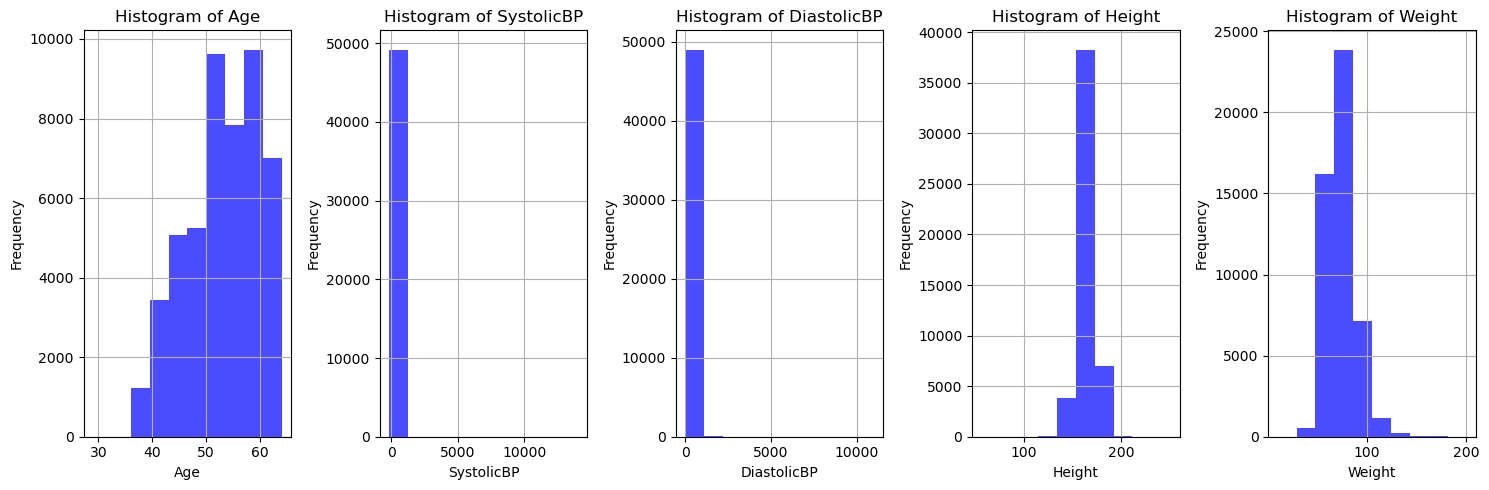

In [13]:
plot_hist(training, ["Age", "SystolicBP", "DiastolicBP", "Height", "Weight"])

The above histograms show the distribution of the numeric values. Height and Weight appear to follow a normal distribution. Age appears to be skewed towards the right. The two most concering graphs are related to the blood pressures. The graphs appear to be highly skewed to the left which further reinforces our concerns with regards to outliers.

In [14]:
training_cleaned = remove_outliers(training, ['SystolicBP', 'DiastolicBP'], threshold = 2.5)
training_cleaned.count()

48485

In [15]:
get_statistics(training_cleaned, 'SystolicBP')
print(' ')
get_statistics(training_cleaned, 'DiastolicBP')

SystolicBP Statistics
+----+------+-----+---+
| Min|Median| Mean|Max|
+----+------+-----+---+
|-150|   120|126.3|401|
+----+------+-----+---+

 
DiastolicBP Statistics
+---+------+----+---+
|Min|Median|Mean|Max|
+---+------+----+---+
|  0|    80|81.4|190|
+---+------+----+---+



In [16]:
determine_skewness(training_cleaned, 'SystolicBP')
print(' ')
determine_skewness(training_cleaned, 'DiastolicBP')

Determining if SystolicBP is skewed
Column is not highly skewed: 0.016402786992653323
 
Determining if DiastolicBP is skewed
Column is not highly skewed: 0.38743306331319083


With a bit of tuning, the 3 z-score threshold was determined to be the best for removing outlier values. After cleaning up outliers and negative values, we can see that the range for both variables is far more reasonable than before. Something to note is that our median values for Systolic BP and Diastolic BP, perfectly match the upper limit to be considered "normal" blood pressure levels.

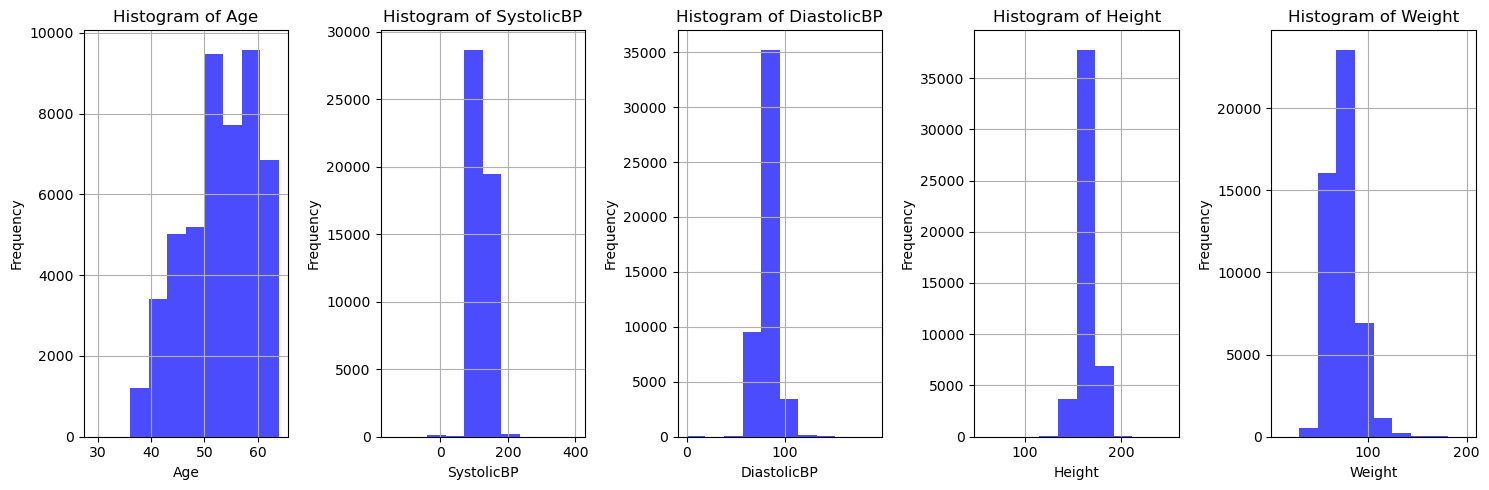

In [17]:
plot_hist(training_cleaned, ["Age", "SystolicBP", "DiastolicBP", "Height", "Weight"])

From the above plots we can confirm that both blood pressure values now follow a normal distribution

### Binning <a name="bin"></a>

Instead of removing observations in our dataset, another solution to help solve the outlier issue is to convert blood pressure values from continuous to discrete via binning, and fortunately, blood pressure values are easy to bin.

In [18]:
bp_data = [
    ("Low Blood Pressure", " < 90", " < 60"), 
    ("Normal Blood Pressure", "90 - 119", "60 - 69"),
    ("Elevated Blood Pressure", "120 - 129", "70 - 79"),
    ("High Blood Pressure Stage 1", "130 - 139", "80 - 89"),
    ("High Blood Pressure Stage 2", "140 - 179", "90 - 119"),
    ("Hyptertensive Crisis", "180+", "120+"),
]
columns = ["Category", "Systolic", "Diastolic"]
bp_df = pd.DataFrame(bp_data, columns=columns)
print(bp_df.to_markdown(index=False))

| Category                    | Systolic   | Diastolic   |
|:----------------------------|:-----------|:------------|
| Low Blood Pressure          | < 90       | < 60        |
| Normal Blood Pressure       | 90 - 119   | 60 - 69     |
| Elevated Blood Pressure     | 120 - 129  | 70 - 79     |
| High Blood Pressure Stage 1 | 130 - 139  | 80 - 89     |
| High Blood Pressure Stage 2 | 140 - 179  | 90 - 119    |
| Hyptertensive Crisis        | 180+       | 120+        |


With these 6 bins on hand, we can transform our blood pressure values into these discrete values.

In [19]:
def bin_bp(df):
    df = df.withColumn("SystolicBP_Group", when(training['SystolicBP'] < 90, 'Low Blood Pressure') \
                        .when((training['SystolicBP'] >= 90) & (training['SystolicBP'] < 120), "Normal Blood Pressure") \
                        .when((training['SystolicBP'] >= 120) & (training['SystolicBP'] < 130), "Elevated Blood Pressure") \
                        .when((training['SystolicBP'] >= 130) & (training['SystolicBP'] < 140), "High Blood Pressure Stage 1") \
                        .when((training['SystolicBP'] >= 140) & (training['SystolicBP'] < 180), "High Blood Pressure Stage 2") \
                        .when(training['SystolicBP'] >= 180, "Hyptertensive Crisis") \
                        .otherwise("Unknown"))
    df = df.withColumn("DiastolicBP_Group", when(training['DiastolicBP'] < 60, 'Low Blood Pressure') \
                        .when((training['DiastolicBP'] >= 60) & (training['DiastolicBP'] < 70), "Normal Blood_Pressure") \
                        .when((training['DiastolicBP'] >= 70) & (training['DiastolicBP'] < 80), "Elevated Blood Pressure") \
                        .when((training['DiastolicBP'] >= 80) & (training['DiastolicBP'] < 90), "High Blood Pressure Stage 1") \
                        .when((training['DiastolicBP'] >= 90) & (training['DiastolicBP'] < 120), "High Blood Pressure Stage 2") \
                        .when(training['DiastolicBP'] >= 120, "Hyptertensive Crisis") \
                        .otherwise("Unknown"))
    return df

training_binned = bin_bp(training)
training_binned.select("DiastolicBP", "DiastolicBP_Group", "SystolicBP", "SystolicBP_Group").show(5, truncate=False)

+-----------+---------------------------+----------+---------------------------+
|DiastolicBP|DiastolicBP_Group          |SystolicBP|SystolicBP_Group           |
+-----------+---------------------------+----------+---------------------------+
|80         |High Blood Pressure Stage 1|110       |Normal Blood Pressure      |
|90         |High Blood Pressure Stage 2|140       |High Blood Pressure Stage 2|
|100        |High Blood Pressure Stage 2|150       |High Blood Pressure Stage 2|
|60         |Normal Blood_Pressure      |100       |Normal Blood Pressure      |
|90         |High Blood Pressure Stage 2|130       |High Blood Pressure Stage 1|
+-----------+---------------------------+----------+---------------------------+
only showing top 5 rows



### Categorical Data Analysis <a name="cat"></a>

In [20]:
for var in ['Glucose', 'Cholesterol', 'Gender', 'Smoking', 'Active', 'Alcohol', 'Cardio', 'DiastolicBP_Group', 'SystolicBP_Group']:
    get_value_counts(training_binned, var)
    print(' ')

Total number of unique values in Glucose: 3
Glucose Value Counts
+-----------------+-----+
|          Glucose|Count|
+-----------------+-----+
|     Above Normal| 3638|
|           Normal|41710|
|Well Above Normal| 3829|
+-----------------+-----+

 
Total number of unique values in Cholesterol: 3
Cholesterol Value Counts
+-----------------+-----+
|      Cholesterol|Count|
+-----------------+-----+
|     Above Normal| 6756|
|           Normal|36653|
|Well Above Normal| 5768|
+-----------------+-----+

 
Total number of unique values in Gender: 2
Gender Value Counts
+------+-----+
|Gender|Count|
+------+-----+
|   Men|17112|
| Women|32065|
+------+-----+

 
Total number of unique values in Smoking: 2
Smoking Value Counts
+-------+-----+
|Smoking|Count|
+-------+-----+
|     No|44919|
|    Yes| 4258|
+-------+-----+

 
Total number of unique values in Active: 2
Active Value Counts
+------+-----+
|Active|Count|
+------+-----+
|    No| 9633|
|   Yes|39544|
+------+-----+

 
Total number of 

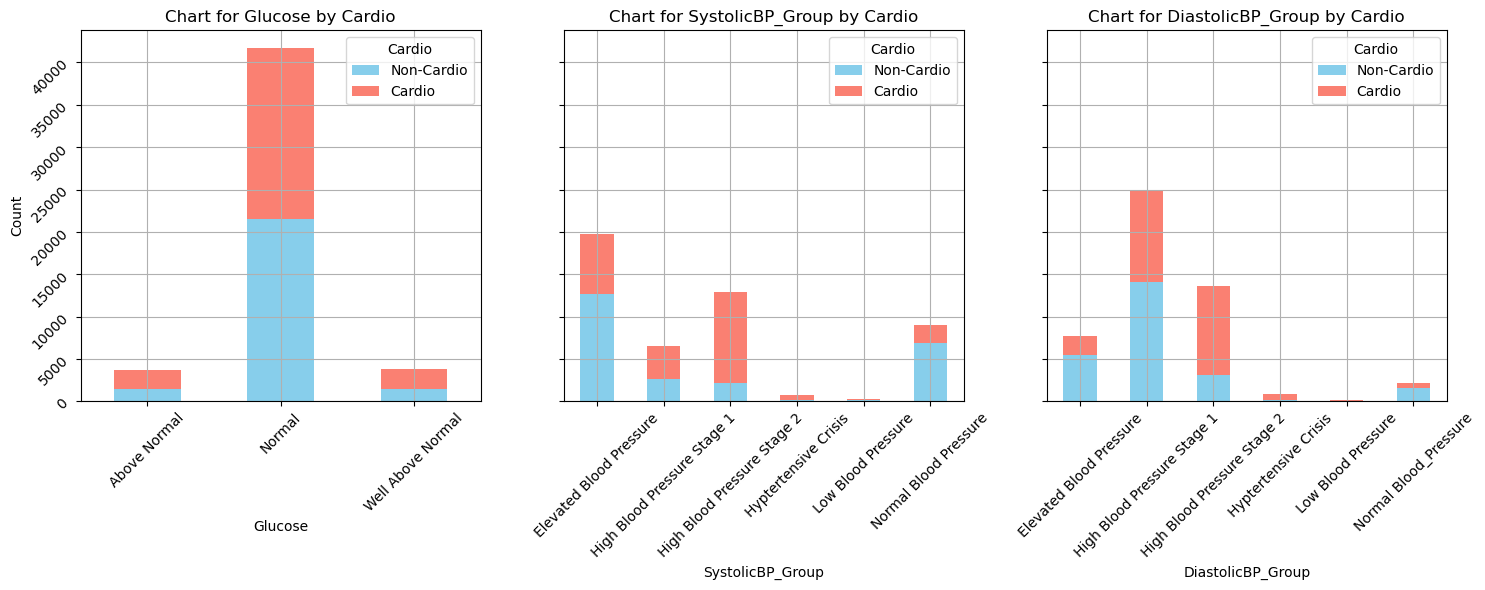

In [21]:
plot_bar(training_binned, ['Glucose', 'SystolicBP_Group', 'DiastolicBP_Group'], 'Cardio')

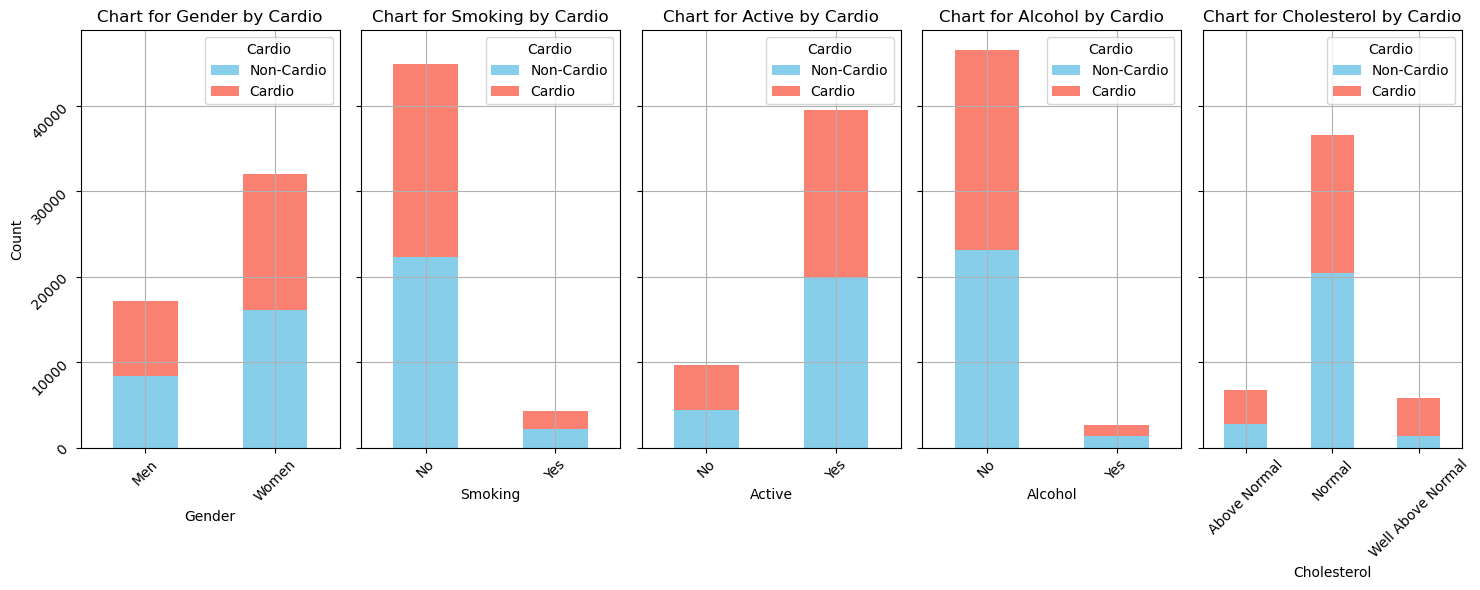

In [22]:
plot_bar(training_binned, ['Gender', 'Smoking', 'Active', 'Alcohol', 'Cholesterol'], 'Cardio')

The above bar plots shows the distribution of our categorical value levels and their relationship with the Cardio variable. For the most part there appears to be a near even split between cardio/non-cardio for each variable level with a few exceptions.

Observations with a well above normal cholesterol appear to have a higher in higher risk of cardiovascualar issues.Similarly, those with high blood pressure (stage 2) and hypertensive crises also appear to be at risk. On the opposite spectrum, those with elevated and normal blood pressure appear to be less at risk.

## 4. Machine Learning <a name="ml"></a>
---

In [23]:
def build_pipeline(df):
    num_cols = ['Age','Height', 'Weight']
    cat_cols = ['Glucose', 'Gender', 'Cholesterol', 'Smoking', 'Active', 'Alcohol', 'SystolicBP_Group', 'DiastolicBP_Group']
    label_col = "Cardio"    
    df = bin_bp(df)
    indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cat_cols]
    encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in cat_cols]
    input_cols = num_cols + [col+"_encoded" for col in cat_cols]
    assembler = VectorAssembler(inputCols=input_cols, outputCol="assembled_features")
    label_indexer = StringIndexer(inputCol=label_col, outputCol="label")
    scaler = StandardScaler(inputCol="assembled_features", outputCol="features")
    stages = [assembler, label_indexer, scaler]
    pipeline = Pipeline(stages=indexers + encoders + stages)
    pipeline_model = pipeline.fit(df)
    return pipeline_model.transform(df).select('features', 'label'), pipeline_model

def data_modeling(df, model):
    df = bin_bp(df)
    return model.transform(df).select('features', 'label')

In [24]:
classifiers = {
    "Base Model": {
        "classifier": LogisticRegression(),
        # Base Values for LR
         "params": {
            "regParam": [0], 
            "elasticNetParam": [0], 
            "maxIter": [100]
        }
    },
    "Logistic Regression": {
        "classifier": LogisticRegression(),
        "params": {
            "regParam": [0, 0.001, 0.01, 0.1, 1, 10], 
            "elasticNetParam": [0, 1], 
            "maxIter": [20, 50, 100, 200]
        }
    },
    "Decision Tree": {
        "classifier": DecisionTreeClassifier(),
        "params": {
            "maxBins": [2, 4, 8, 16, 32],
            "maxDepth": [2, 5, 10]
        }
    },
    "Random Forest": {
        "classifier": RandomForestClassifier(seed=123),
        "params": {
            "featureSubsetStrategy": ['auto', 'all', 'onethird', 'sqrt', 'log2'],
            "maxBins": [2, 4, 8, 16, 32],
            "maxDepth": [2, 5, 10],
            "numTrees": [5, 10, 20, 50]
        }
    },
    "Gradient-Boosted Tree": {
        "classifier": GBTClassifier(seed=123),
        "params": {
            "featureSubsetStrategy": ['auto', 'all', 'onethird', 'sqrt', 'log2'],
            "maxBins": [2, 4, 8, 16, 32],
            "stepSize": [0.00001, 0.0001, 0.001, 0.01],
            "maxDepth": [2, 5, 10]
        }
    },
    "Multi-Layer Perceptron": {
        "classifier": MultilayerPerceptronClassifier(layers=[21, 42, 84, 2], seed=123),
        "params": {
            "solver": ['l-bfgs', 'gd'],
            "maxIter": [5, 10, 25, 50, 100],
            "stepSize": [0.00001, 0.0001, 0.001, 0.01]
        }
    }
}

In [25]:
tr, pipeline_model = build_pipeline(training)
ts = data_modeling(test, pipeline_model)

results = []
for classifier_name, classifier in classifiers.items():
    print(f"Executing classifier: {classifier_name}")
    print('----------------------------------')
    estimator = classifier["classifier"]
    evaluator = MulticlassClassificationEvaluator()
    param_grid = ParamGridBuilder()
    for param_name, param_values in classifier["params"].items():
        param_grid = param_grid.addGrid(getattr(estimator, param_name), param_values)
    param_grid = param_grid.build()
    cv = CrossValidator(estimator=estimator, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
    model = cv.fit(tr)
    predictions = model.transform(ts)
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    log_loss = evaluator.evaluate(predictions, {evaluator.metricName: "logLoss"})
    features_str = ""
    for param_name, param_values in classifier["params"].items():
        mod_param_name = "get" + param_name[0].upper() + param_name[1:]
        param_attr = getattr(model.bestModel, mod_param_name)
        if callable(param_attr):
            param_attr = param_attr()            
        features_str = features_str + f"{param_name}: {param_attr} |"
    features_str = features_str.rstrip(features_str[-1])
    results.append((classifier_name, round(accuracy, 4), round(log_loss, 4), features_str))   

Executing classifier: Base Model
----------------------------------
Executing classifier: Logistic Regression
----------------------------------
Executing classifier: Decision Tree
----------------------------------
Executing classifier: Random Forest
----------------------------------
Executing classifier: Gradient-Boosted Tree
----------------------------------
Executing classifier: Multi-Layer Perceptron
----------------------------------


In [26]:
columns = ["Classifier", "Accuracy", "Log Loss", "Features"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df.to_markdown(index=False))

| Classifier             |   Accuracy |   Log Loss | Features                                                                   |
|:-----------------------|-----------:|-----------:|:---------------------------------------------------------------------------|
| Base Model             |     0.7351 |     0.5492 | regParam: 0.0 |elasticNetParam: 0.0 |maxIter: 100                          |
| Logistic Regression    |     0.7351 |     0.5491 | regParam: 0.0 |elasticNetParam: 0.0 |maxIter: 20                           |
| Decision Tree          |     0.7316 |     0.678  | maxBins: 4 |maxDepth: 10                                                   |
| Random Forest          |     0.7382 |     0.5419 | featureSubsetStrategy: onethird |maxBins: 32 |maxDepth: 10 |numTrees: 50   |
| Gradient-Boosted Tree  |     0.7321 |     0.5521 | featureSubsetStrategy: onethird |maxBins: 16 |stepSize: 0.01 |maxDepth: 10 |
| Multi-Layer Perceptron |     0.7371 |     0.5401 | solver: l-bfgs |maxIter: 100 |stepSiz

In [27]:
spark.stop()

## 5. Conclusion <a name="conc"></a>

After running our models it appears that all models perfromed nearly the same in terms of accuracy. Similarly, the log loss for all but the Decision Tree model also appear to be close in value.

The performance of our models a result of our data. More than half of our explanatory variables were categorical variables, and from the analysis of these variables in an earlier section, most of the data did not show a trend in either direction. 

One of the difficulties working with this dataset was trying to understand some of these categorical variables, i.e. what defines a person as active, someone who performs minimal physical activity, or someone who is in peak athletic condition. The data appears to be too generalized. Data with more descriptive values or having these variables be numeric could potentially help our models understand what is going on in the underlying data.

Looking at our models, if one was to chosen to help estimate for cardiovascular disease detection, either the random forest or logistic regression model would suffice. The multi-layer perceptron and gradient-boosted tree models are too complex for the results given, and the decision tree model has too high a log-loss compared to our other models.